In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from itertools import combinations
import anndata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scvi

import plotting_functions as pf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plate_palette = sns.color_palette("husl", n_colors=3)
geno_palette = ['#DA9CC1', '#F4C245', '#C0BFBF', '#55AF5B', '#4F6EAF', '#52A5DB', '#D83026', '#683C91']


# QC plotting - 200 /500 UMI merged adata

In [5]:
adata = sc.read("../IGVF_analysis/preprocessed_tissues/GonadsMalepreprocessed.h5ad")


In [6]:
adata.layers['raw_counts'] = adata.X.copy()


In [7]:
adata

AnnData object with n_obs × n_vars = 1355404 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'WSBJ', 'NZOJ', 'AJ', 'PWKJ', 'B6J', 'NODJ', '129S1J', 'CASTJ', 'doublet_scores', 'batch'
    var: 'gene_name'
    layers: 'raw_counts'

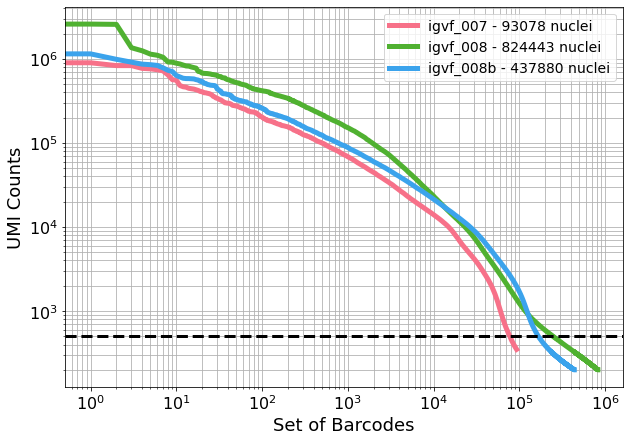

In [8]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

In [9]:
# set var names to be gene names, not gene ID
adata.var_names  = adata.var['gene_name']
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


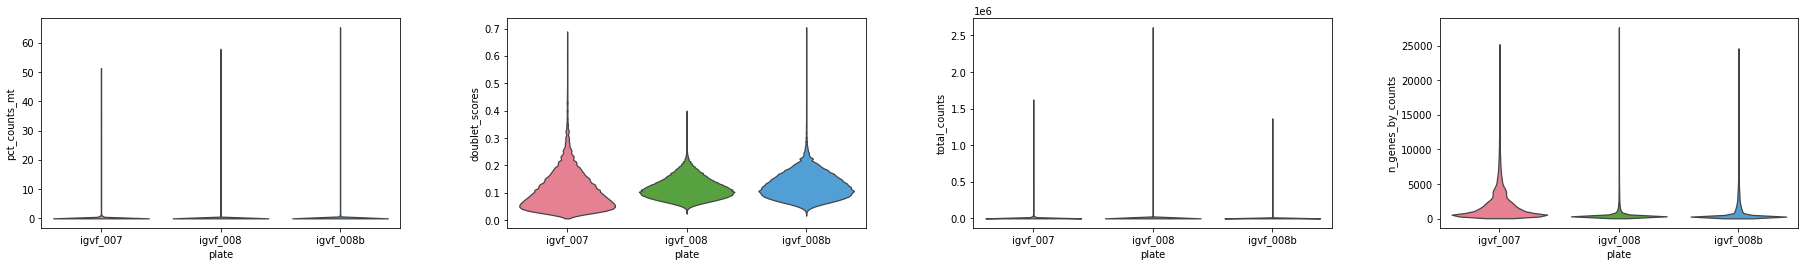

In [10]:
plate_palette = sns.color_palette("husl", n_colors=3)

sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

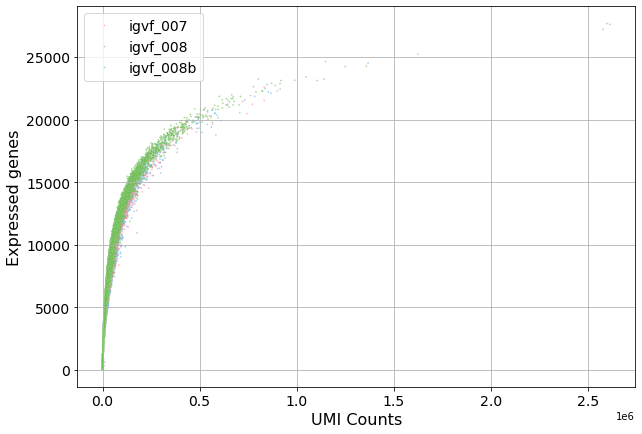

In [11]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

In [12]:
adatas = adata[(adata.obs['total_counts'] < 10000) & (adata.obs['n_genes_by_counts'] < 2000), :]


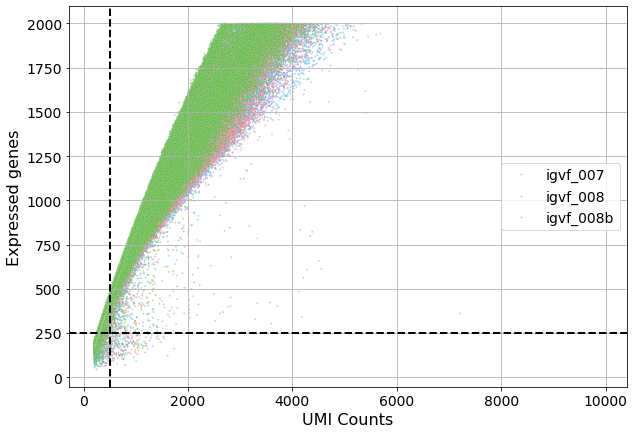

In [13]:
pf.plot_genes_by_counts(adatas, category_column='plate', figsize=(10, 7))

plt.axvline(x=500, color='k', linestyle='--', linewidth=2)
plt.axhline(y=250, color='k', linestyle='--', linewidth=2)

plt.show()

In [14]:
adatas[(adatas.obs['total_counts'] > 500) & (adatas.obs['n_genes_by_counts'] < 250), :]


View of AnnData object with n_obs × n_vars = 263 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'WSBJ', 'NZOJ', 'AJ', 'PWKJ', 'B6J', 'NODJ', '129S1J', 'CASTJ', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

# QC plotting - filtered data
500 UMI, 250 genes, 1% mito, 0.25 doublet score


In [3]:
adata = sc.read("../IGVF_analysis/tissue_processed_500umi/GonadsMale_processed.h5ad")


In [4]:
print(adata.obs['Genotype'].value_counts())

adata = adata[adata.obs['Genotype'] != "tie",:]

print(adata.obs['Genotype'].value_counts())

Genotype
NODJ      72817
WSBJ      70993
B6J       60283
NZOJ      59765
AJ        58518
129S1J    52449
CASTJ     51487
PWKJ      50811
tie         206
Name: count, dtype: int64
Genotype
NODJ      72817
WSBJ      70993
B6J       60283
NZOJ      59765
AJ        58518
129S1J    52449
CASTJ     51487
PWKJ      50811
Name: count, dtype: int64


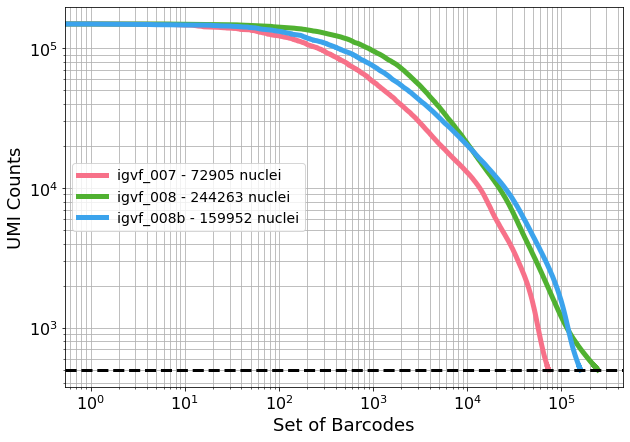

In [5]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

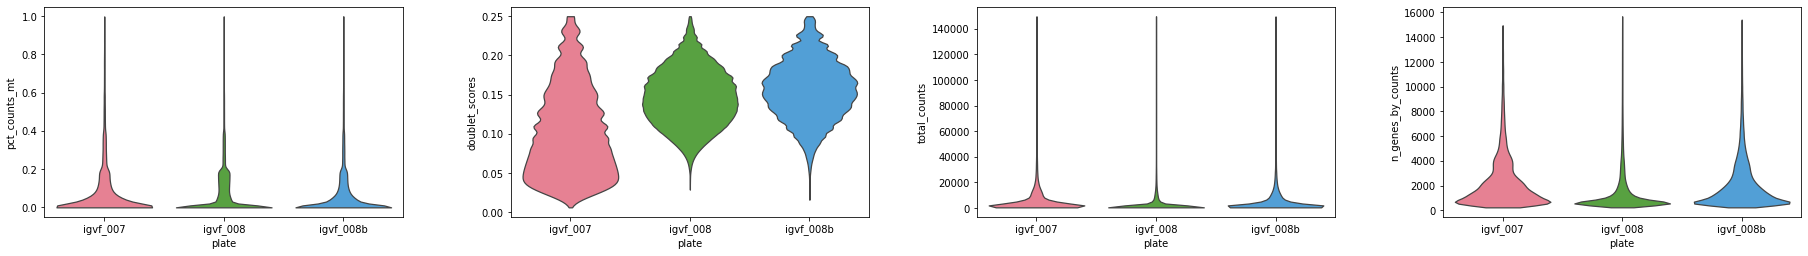

In [6]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

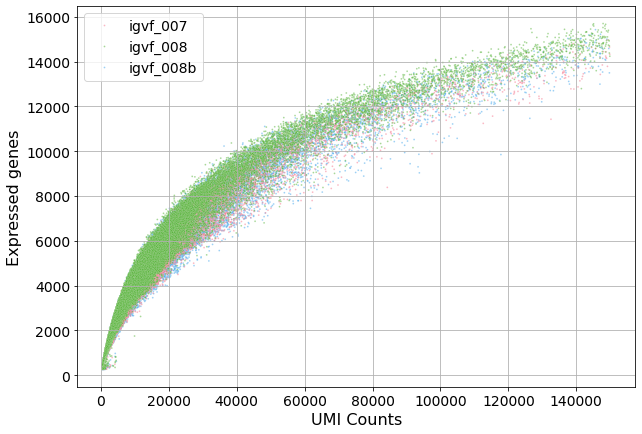

In [7]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

# Check clustering
Plate, sex, genotype

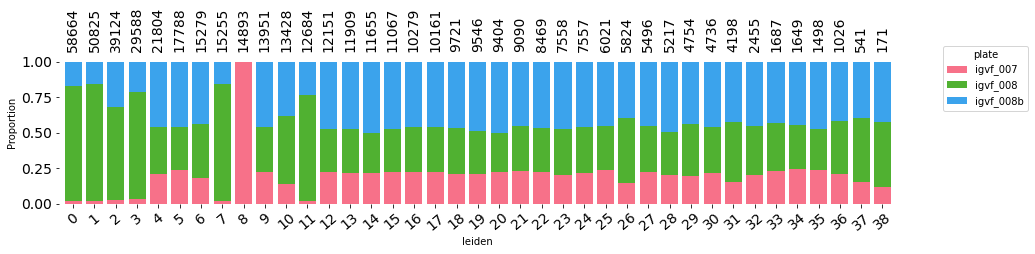

In [8]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'plate',
                            flip=False, fsize = (15,3), 
                            annotations = True)


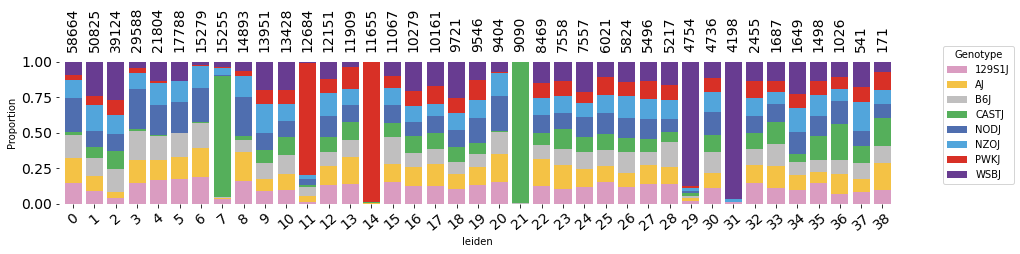

In [9]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=False, fsize = (15,3), 
                            annotations = True)


In [ ]:
# # adjust mouse_tissue_id
# # sample genotypes for each 'Multiplexed_sampleN'
# ms1 = ['B6J','AJ','WSBJ','129S1J']
# ms2 = ['NODJ','PWKJ','NZOJ','CASTJ']

# # Define a function to update 'Mouse_Tissue_ID' based on conditions
# def update_mouse_tissue_id(row):
#     if row['plate'] != 'igvf_012' and row['Column'] in [9.0, 10.0, 11.0, 12.0]:
#         if row['Genotype'] in ms1:
#             return row['Multiplexed_sample1']
#         elif row['Genotype'] in ms2:
#             return row['Multiplexed_sample2']
#     return row['Mouse_Tissue_ID']

# meta = adata.obs

# # Apply the function to update the 'Mouse_Tissue_ID' column
# meta['Mouse_Tissue_ID'] = meta.apply(update_mouse_tissue_id, axis=1)
# adata.obs['Mouse_Tissue_ID'] = meta['Mouse_Tissue_ID']
# pf.stacked_barplot_proportions(adata.obs, 
#                                'leiden', 'Mouse_Tissue_ID',
#                                flip=False, fsize = (15,3), 
#                                annotations = True)

In [13]:
meta.loc[meta['leiden'] == "31", 'Mouse_Tissue_ID'].value_counts().head()

Mouse_Tissue_ID
057_WSBJ_10M_25    1091
063_WSBJ_10M_25     992
059_WSBJ_10M_25     804
061_WSBJ_10M_25     551
GH_M1_25            237
Name: count, dtype: int64

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


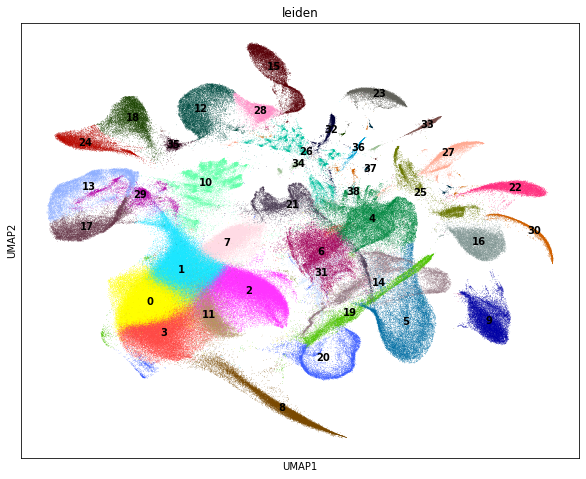

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


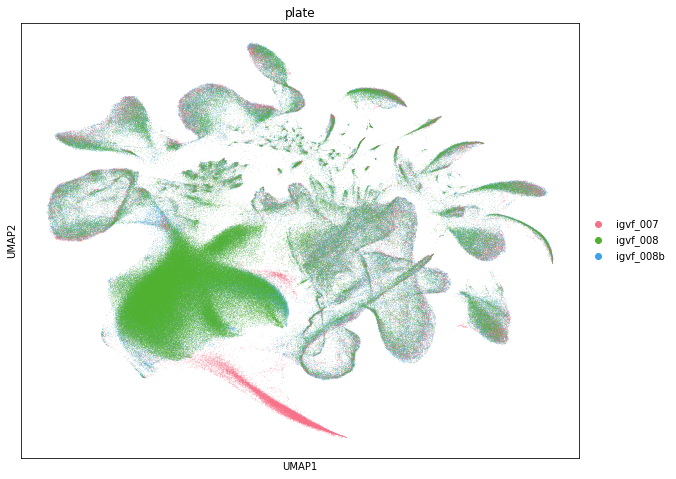

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


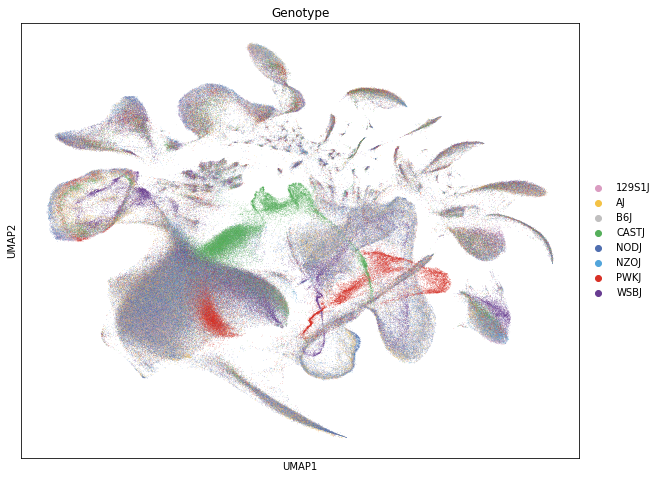

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


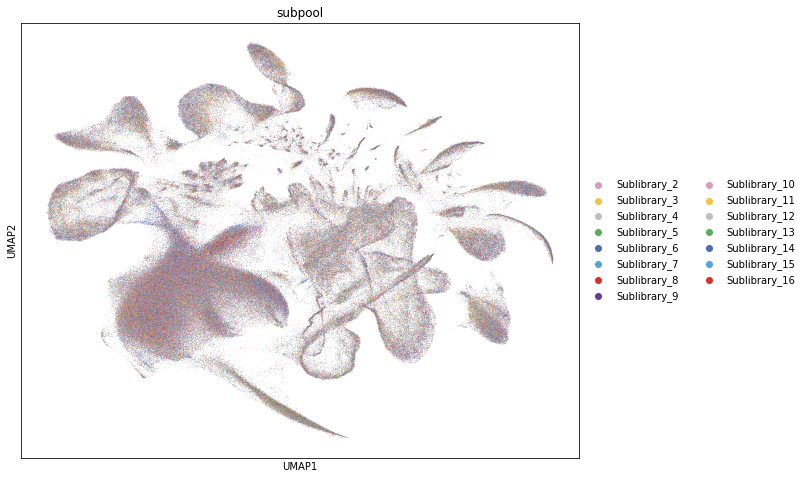

In [14]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(adata, color=['leiden'], size=1, legend_loc = 'on data')

sc.pl.umap(adata, color=['plate'], size = 0.8, palette = plate_palette)

sc.pl.umap(adata, color=['Genotype'], size = 0.8, palette = geno_palette)

sc.pl.umap(adata, color=['subpool'], size = 0.8, palette = geno_palette)




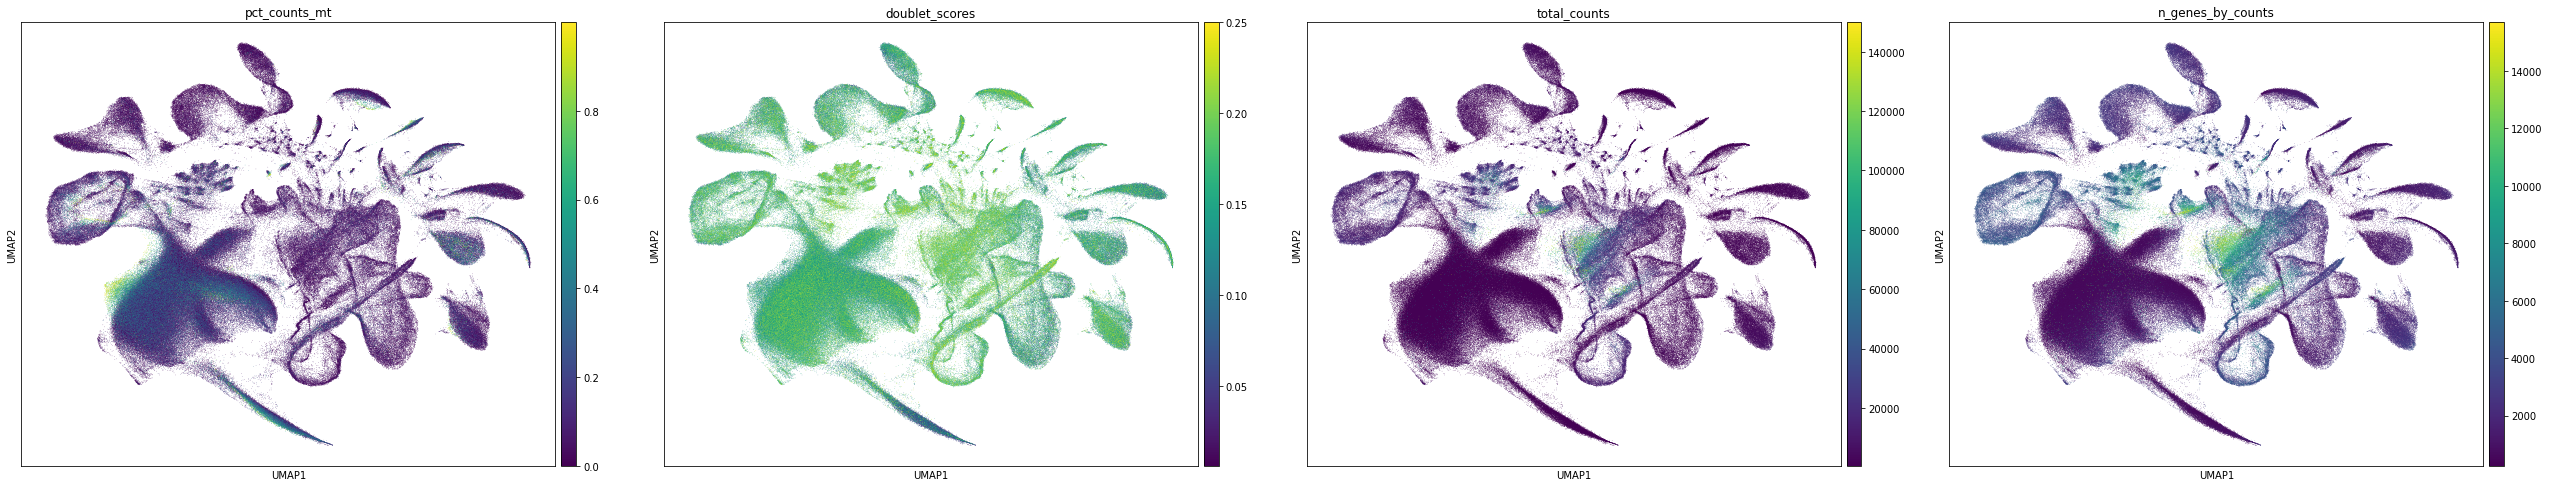

In [15]:
adata.var_names  = adata.var['gene_name']


sc.pl.umap(adata, color=['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'], 
           size = 1, sort_order = True)


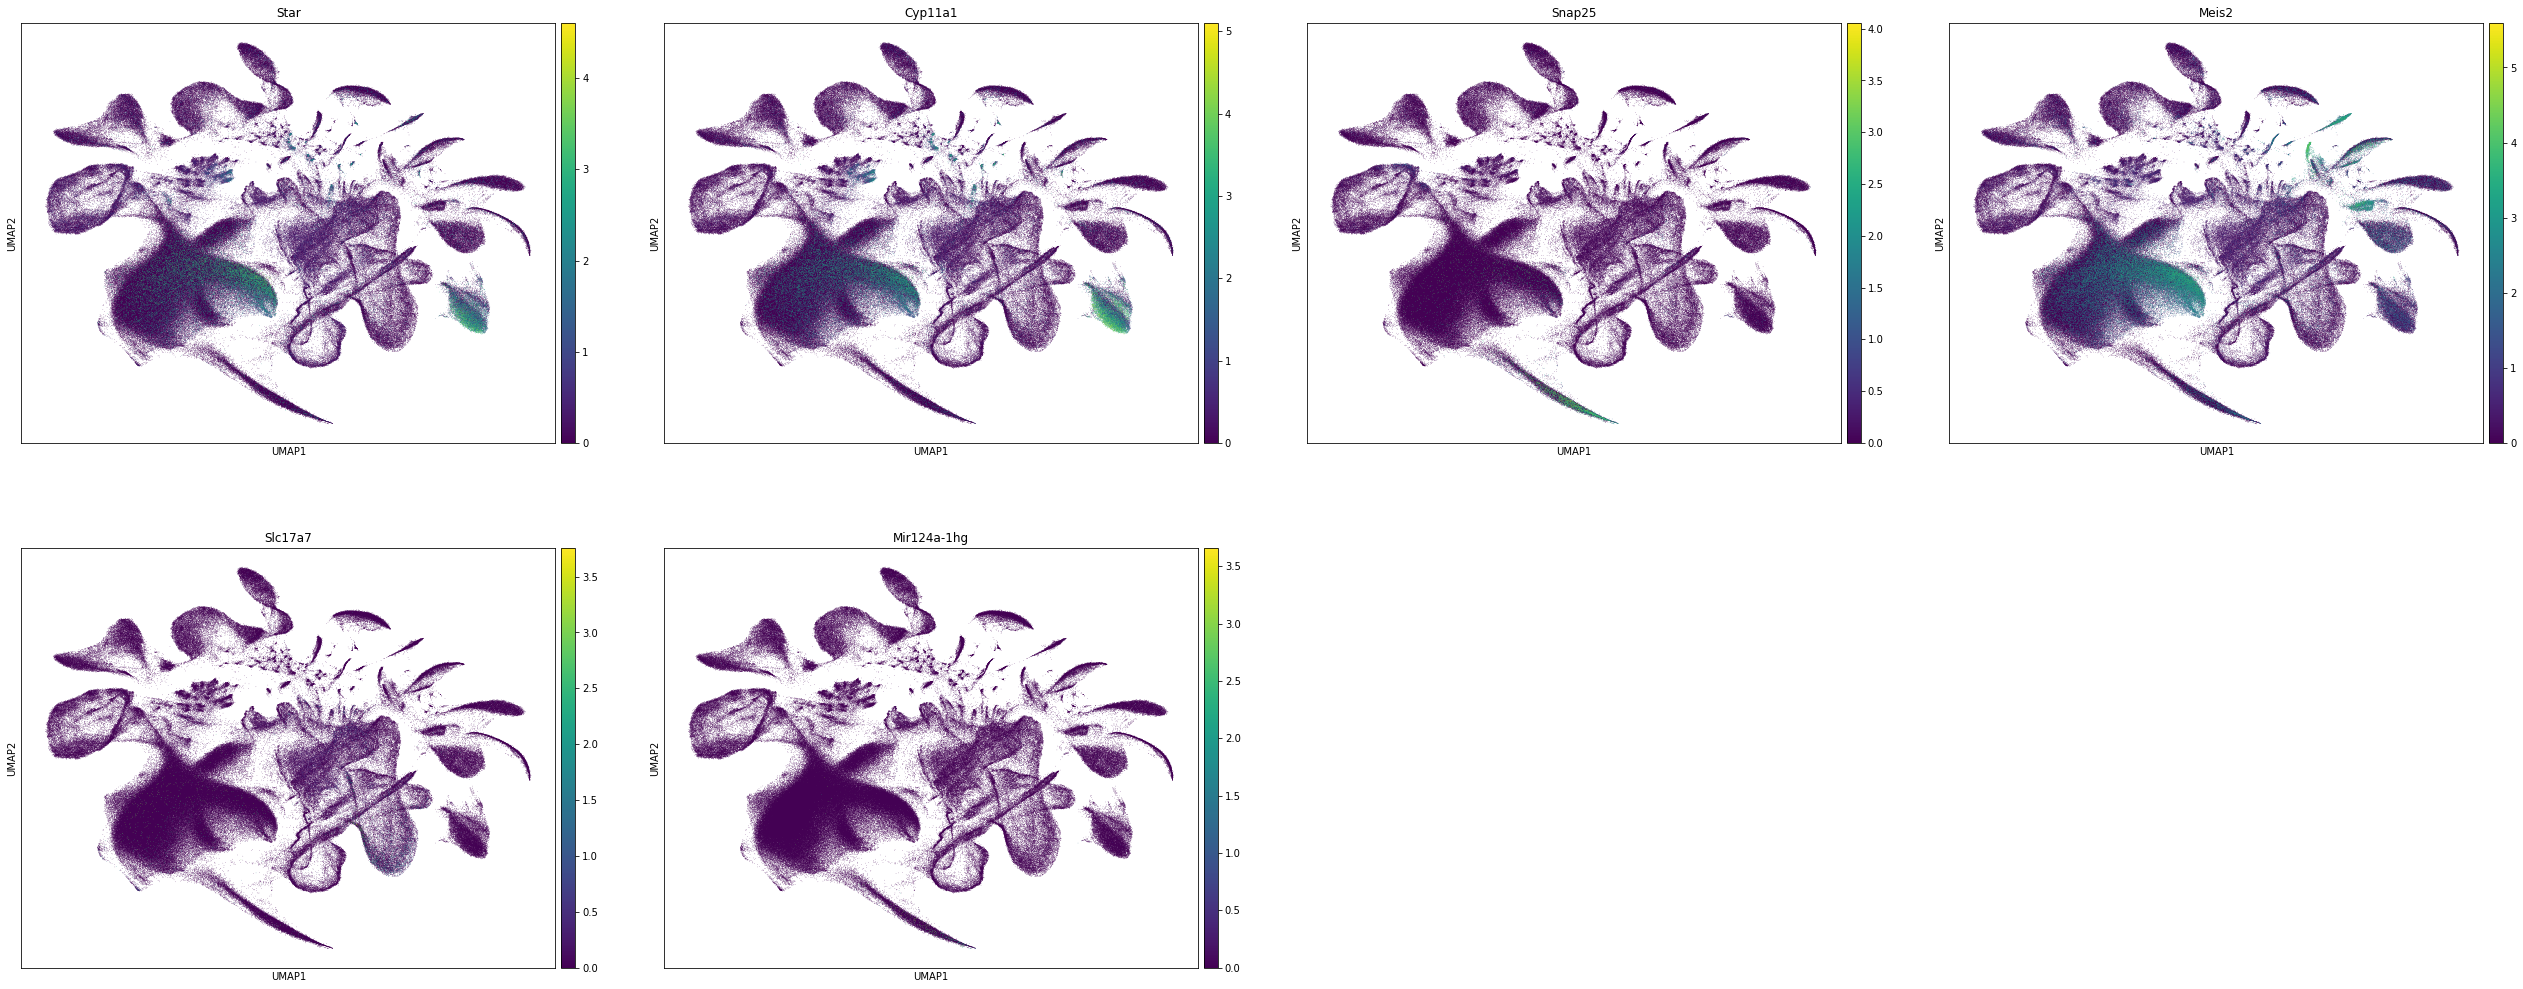

In [16]:
sc.pl.umap(adata, color=['Star','Cyp11a1','Snap25','Meis2','Slc17a7','Mir124a-1hg'], 
           size = 1, sort_order = True)


# Remove large low-quality clusters and re-cluster

In [5]:
adata = adata[~adata.obs['leiden'].isin(["0","1","2","3","7","11","8"])]



In [6]:
adata

View of AnnData object with n_obs × n_vars = 256090 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'WSBJ', 'NZOJ', 'AJ', 'PWKJ', 'B6J', 'NODJ', '129S1J', 'CASTJ', 'doublet_scores', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'

In [7]:
adata.uns['log1p']["base"] = None

In [8]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adatas = adata[:, adata.var.highly_variable]



/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [9]:
sc.pp.regress_out(adatas, ['pct_counts_mt','n_genes_by_counts'])
sc.pp.scale(adatas, max_value=10)

sc.tl.pca(adatas, svd_solver='arpack', use_highly_variable = True)
sc.pp.neighbors(adatas, n_neighbors=20, n_pcs=30)

sc.tl.leiden(adatas, resolution = 1)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarni

In [10]:
sc.tl.umap(adatas, min_dist = 0.5, spread =2.0)

In [ ]:
adata.uns['neighbors'] = adatas.uns['neighbors']
adata.uns['leiden'] = adatas.uns['leiden']
adata.uns['umap'] = adatas.uns['umap']
adata.obs['leiden'] = adatas.obs['leiden']
adata.obsm = adatas.obsm
adata.obsp = adatas.obsp
adata.write_h5ad('../IGVF_analysis/annotated_tissues/GonadsMale_filtered.h5ad')


In [42]:
adata = sc.read('../IGVF_analysis/annotated_tissues/GonadsMale_filtered.h5ad')


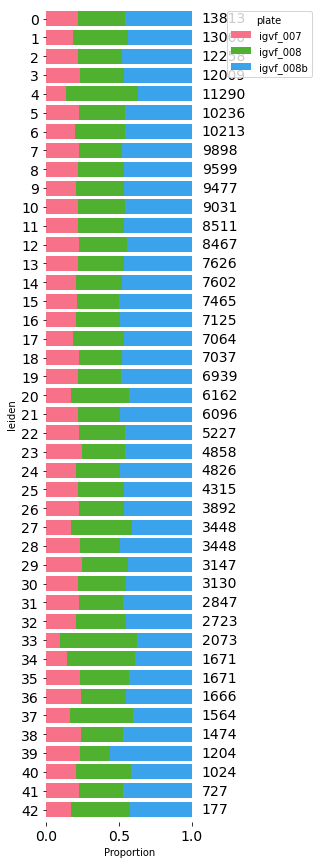

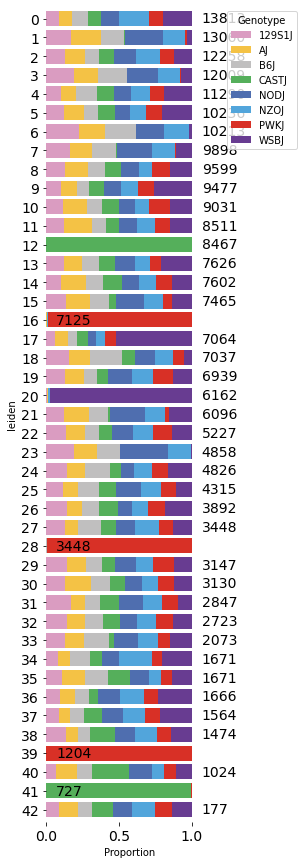

In [4]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'plate',
                            flip=True, fsize = (3,15), 
                            annotations = True)

pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=True, fsize = (3,15), 
                            annotations = True)


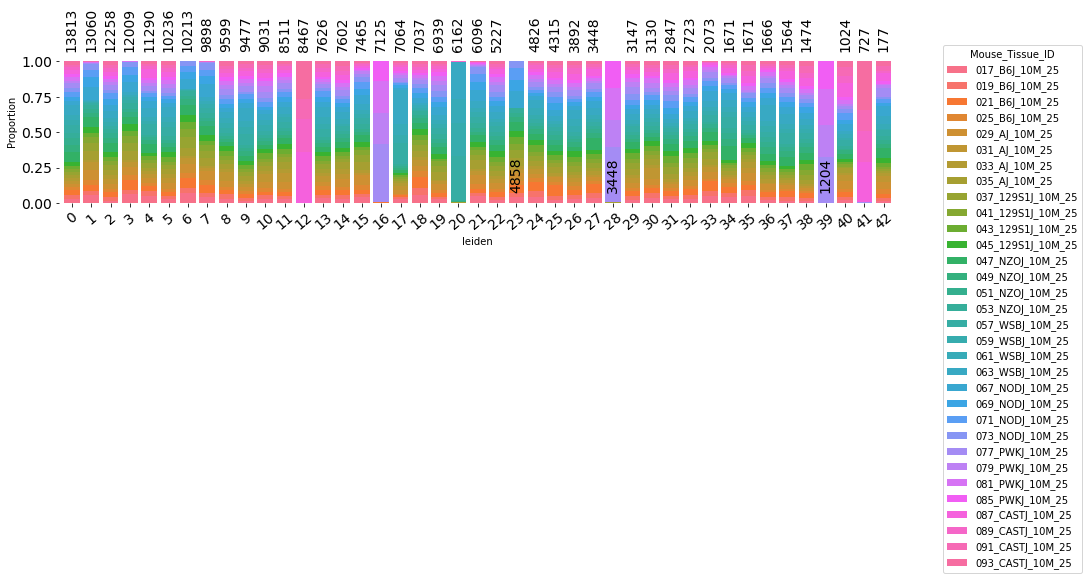

In [5]:
# adjust mouse_tissue_id
# sample genotypes for each 'Multiplexed_sampleN'
ms1 = ['B6J','AJ','WSBJ','129S1J']
ms2 = ['NODJ','PWKJ','NZOJ','CASTJ']

# Define a function to update 'Mouse_Tissue_ID' based on conditions
def update_mouse_tissue_id(row):
    if row['plate'] != 'igvf_012' and row['Column'] in [9.0, 10.0, 11.0, 12.0]:
        if row['Genotype'] in ms1:
            return row['Multiplexed_sample1']
        elif row['Genotype'] in ms2:
            return row['Multiplexed_sample2']
    return row['Mouse_Tissue_ID']

meta = adata.obs

# Apply the function to update the 'Mouse_Tissue_ID' column
meta['Mouse_Tissue_ID'] = meta.apply(update_mouse_tissue_id, axis=1)
adata.obs['Mouse_Tissue_ID'] = meta['Mouse_Tissue_ID']
pf.stacked_barplot_proportions(adata.obs, 
                               'leiden', 'Mouse_Tissue_ID',
                               flip=False, fsize = (15,3), 
                               annotations = True)

In [6]:
adata.obs.loc[adata.obs['leiden'] == "20", 'Mouse_Tissue_ID'].value_counts().head()



Mouse_Tissue_ID
057_WSBJ_10M_25    1914
063_WSBJ_10M_25    1617
059_WSBJ_10M_25    1411
061_WSBJ_10M_25    1065
053_NZOJ_10M_25      47
Name: count, dtype: int64

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


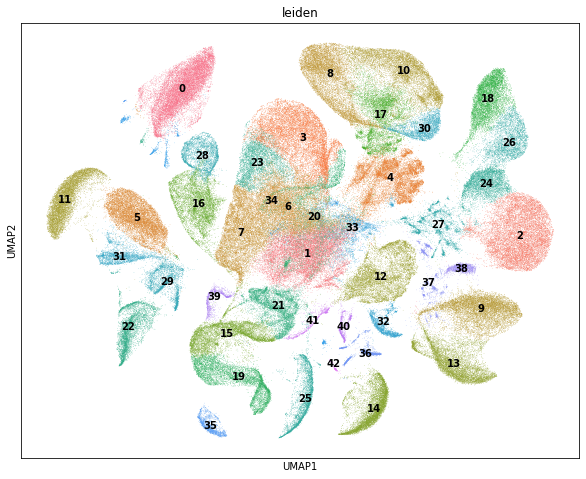

In [7]:
plt.rcParams['figure.figsize'] = (10, 8)

leiden_palette = sns.color_palette("husl", n_colors=51)

sc.pl.umap(adata, color=['leiden'], size=1, legend_loc = 'on data',palette=leiden_palette)




/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


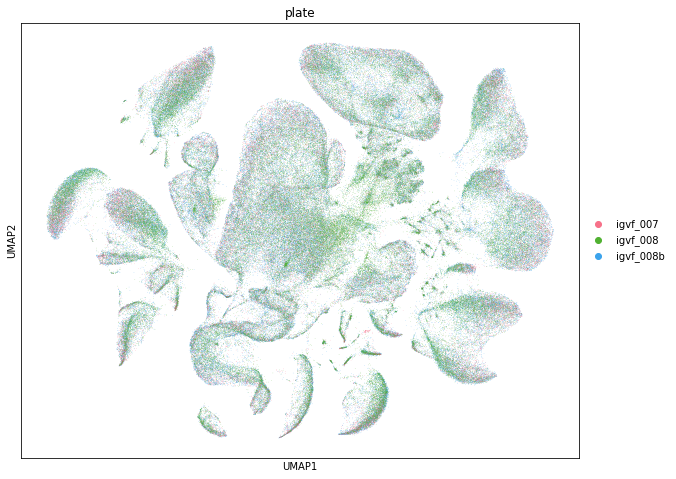

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


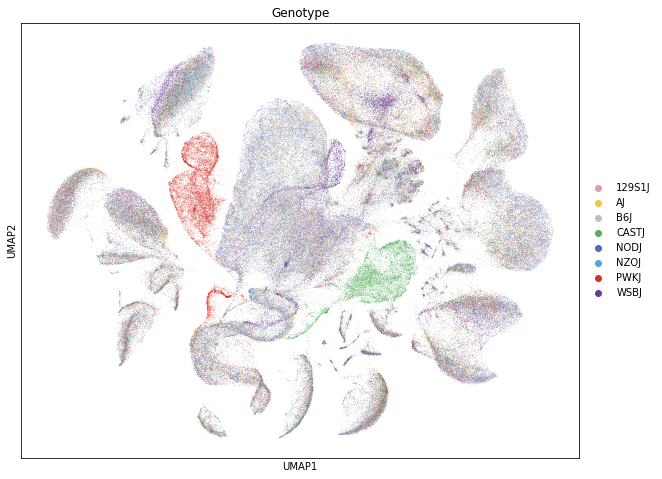

In [8]:
sc.pl.umap(adata, color=['plate'], size = 0.8, palette = plate_palette)

sc.pl.umap(adata, color=['Genotype'], size = 0.8, palette = geno_palette)


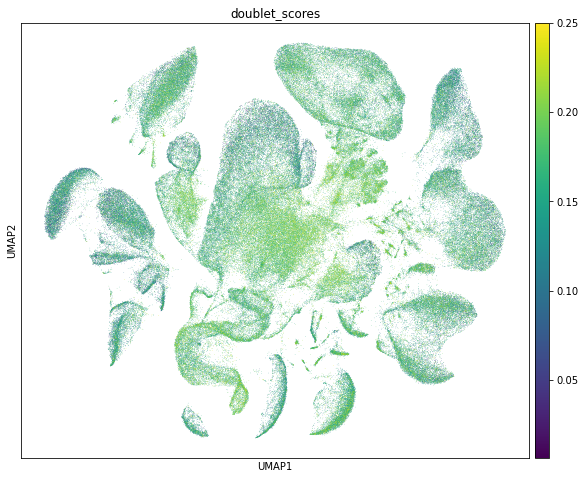

In [9]:
sc.pl.umap(adata, color=['doublet_scores'], size=1)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: UserWarning: The palette list has more values (51) than needed (43), which may not be intended.
  ax = sns.violinplot(


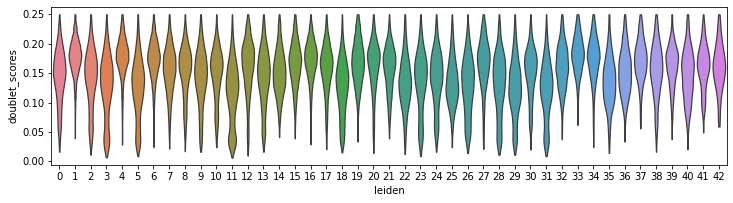

In [10]:
plt.rcParams['figure.figsize'] = (10, 3)

sc.pl.violin(adata, ['doublet_scores'],
             groupby = "leiden", palette = leiden_palette,
             jitter=0.4, multi_panel=True, size=0)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: UserWarning: The palette list has more values (51) than needed (43), which may not be intended.
  ax = sns.violinplot(


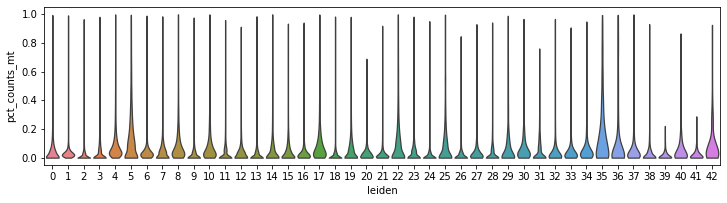

In [11]:
plt.rcParams['figure.figsize'] = (10, 3)

sc.pl.violin(adata, ['pct_counts_mt'],
             groupby = "leiden", palette = leiden_palette,
             jitter=0.4, multi_panel=True, size=0)

# Prepare reference dataset
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145443

In [31]:
from scipy.sparse import csr_matrix


In [34]:
mat = pd.read_csv("../IGVF_analysis/external_ref/GSE145443_raw_SC_epid.tsv", sep="\t")

var = mat[['Gene']].copy()
var.columns = ["gene_name"]


mat = mat.drop(columns=['Gene']).T
X_sparse = csr_matrix(mat)


In [35]:
obs = pd.read_csv("../IGVF_analysis/external_ref/GSE145443_metadata_SC_epid.tsv", sep="\t")


In [36]:
adata = anndata.AnnData(X_sparse, obs=obs, var=var)

adata.obs.index = obs['cell_Barcode']
adata.var_names = adata.var['gene_name']


/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [40]:
adata.write_h5ad('../IGVF_analysis/external_ref/epididymis_vas_deferens_ref.h5ad')


# Label transfer

## Merge and preprocess again

In [49]:
ref_data = sc.read('../IGVF_analysis/external_ref/epididymis_vas_deferens_ref.h5ad')


In [51]:
ref_data.obs['final_celltype'].value_counts()

final_celltype
Connective          975
Basal               917
StemStromalVas      549
PC04                516
PC08                400
PC09                365
PC05                353
PC02                346
PC06                341
PC03                332
StromalIL6          319
BasalLowUM          315
Muscle              262
Endothelial         245
PC14                244
MuscleGfra4         240
PC01                239
AngryVasStromal     226
Clear               216
PC07                183
BasalNotch2         165
Fibroblast          153
PC10                151
PC15                144
PC13                139
PC11                129
Macrophages         104
Narrow               78
PC12                 74
ClearKrt14           54
TCell                44
MacrophagesTrem2     26
Dendritic            21
BasalMacrophages     15
Name: count, dtype: int64

In [ ]:
adata = sc.read('../IGVF_analysis/annotated_tissues/GonadsMale_filtered.h5ad')
adata.var_names  = adata.var['gene_name']

adata = adata.concatenate(ref_data)


In [ ]:
adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata


In [ ]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=2000,
                            layer = "raw_counts", batch_key="batch", subset = True)


## Run scvi

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer = 'raw_counts', batch_key='batch')
vae = scvi.model.SCVI(adata)
vae.train()


In [ ]:
adata.obs['final_celltype'] = adata.obs['final_celltype'].astype('category')

adata.obs['final_celltype'] = adata.obs['final_celltype'].cat.add_categories('Unknown')
adata.obs = adata.obs.fillna(value = {'final_celltype': 'Unknown'})



In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = adata, 
                                         unlabeled_category = 'Unknown',
                                         labels_key = 'final_celltype')

lvae.train(max_epochs=20, n_samples_per_label=100)

adata.obs['predictions'] = lvae.predict(adata)


In [ ]:
adata.obs['cell_barcodes'] = adata.obs.index.map(lambda x: x[:-2])

cell_mapper = dict(zip(adata.obs.cell_barcodes, adata.obs.predictions))

In [ ]:
cell_mapper_df = pd.DataFrame(list(cell_mapper.items()), columns=['cell_barcodes', 'predictions'])


In [ ]:
cell_mapper_df.head()

In [ ]:
cell_mapper_df.to_csv("malegonads_cell_mapper.csv")

## Map back to original data

In [57]:
adata = sc.read('../IGVF_analysis/annotated_tissues/GonadsMale_filtered.h5ad')


In [60]:
cell_mapper = pd.read_csv("malegonads_cell_mapper.csv", index_col = 0)

In [ ]:
adata.obs['predictions'] = adata.obs.index.map(cell_mapper)


In [ ]:
adata.write_h5ad('../IGVF_analysis/annotated_tissues/GonadsMale_filtered.h5ad')


In [64]:
adata = sc.read('../IGVF_analysis/annotated_tissues/GonadsMale_filtered.h5ad')


In [65]:
plt.rcParams['figure.figsize'] = (10, 8)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


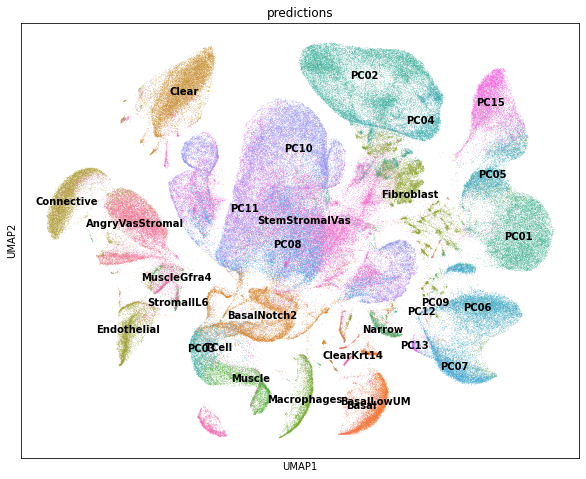

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


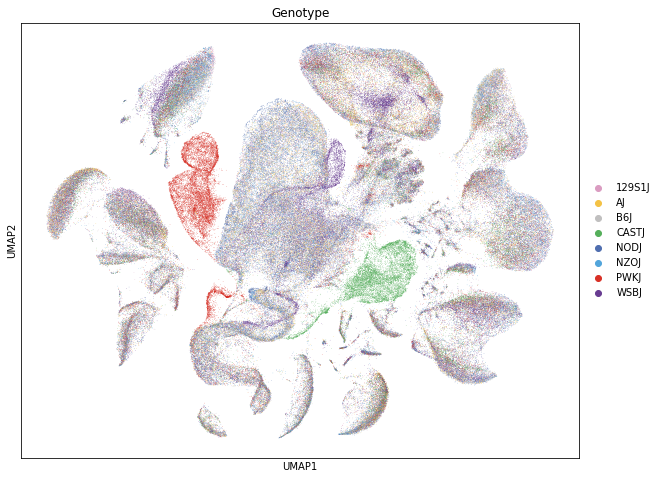

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


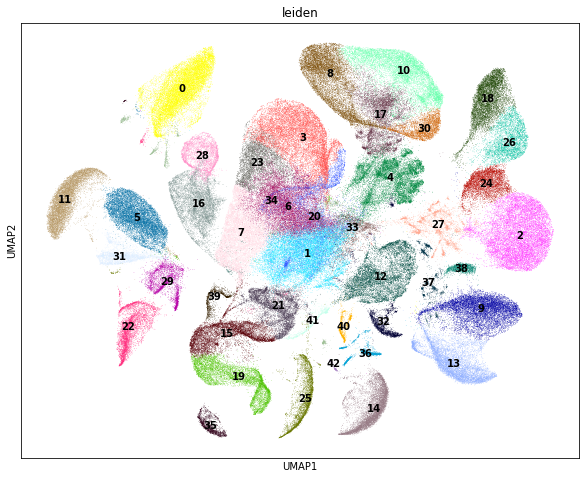

In [66]:
color_palette = sns.color_palette("husl", n_colors=30)

sc.pl.umap(adata, color=['predictions'], size=1, legend_loc = 'on data',palette=color_palette)
sc.pl.umap(adata, color=['Genotype'], size=1,palette=geno_palette)
sc.pl.umap(adata, color=['leiden'], size=1,legend_loc = 'on data')



# Check marker gene expression

In [67]:
adata.var_names  = adata.var['gene_name']


In [72]:
marker_genes_dict = {
    "Caput": ["Lcn8","Defb12","Gpx5","Cst12","Rnase10","Agr2","Bmyc","Pemt","Spink11","Mettl7a1","Etv5","Ido1","Ifngr2","Exosc6"],
    "Corpus": ["Spint4","Cyp17a1","Car3","Gdf11","Npy","Aqp6","Hexb","Aspg","Rnase11","Agt"],
    "Cauda": ["Spink14","S100a8","Defb2","Smarca1"],
    "Other mettls": ["Mettl3","Mettl14"],          
               
}



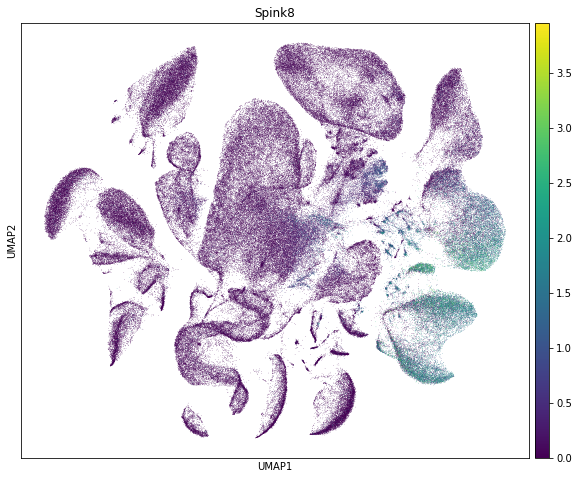

In [93]:
sc.pl.umap(adata, color=['Spink8'], size=1, sort_order = True)


categories: 0, 1, 2, etc.
var_group_labels: Caput, Corpus, Cauda, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


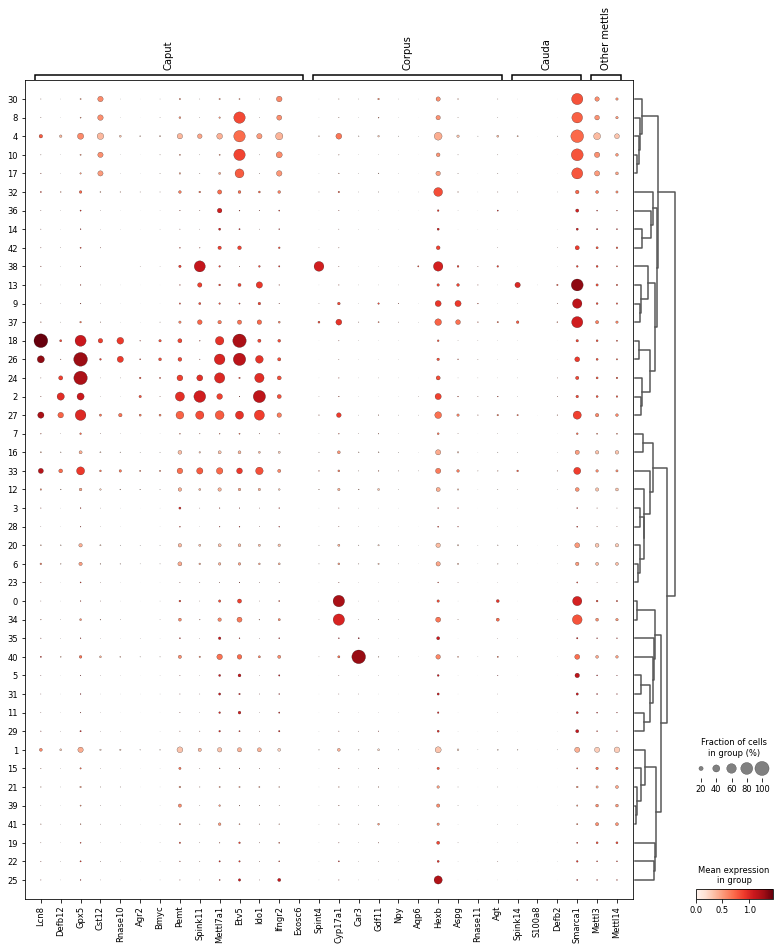

In [73]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


categories: 0, 1, 2, etc.
var_group_labels: Basal_cell, Clear_cell, Endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


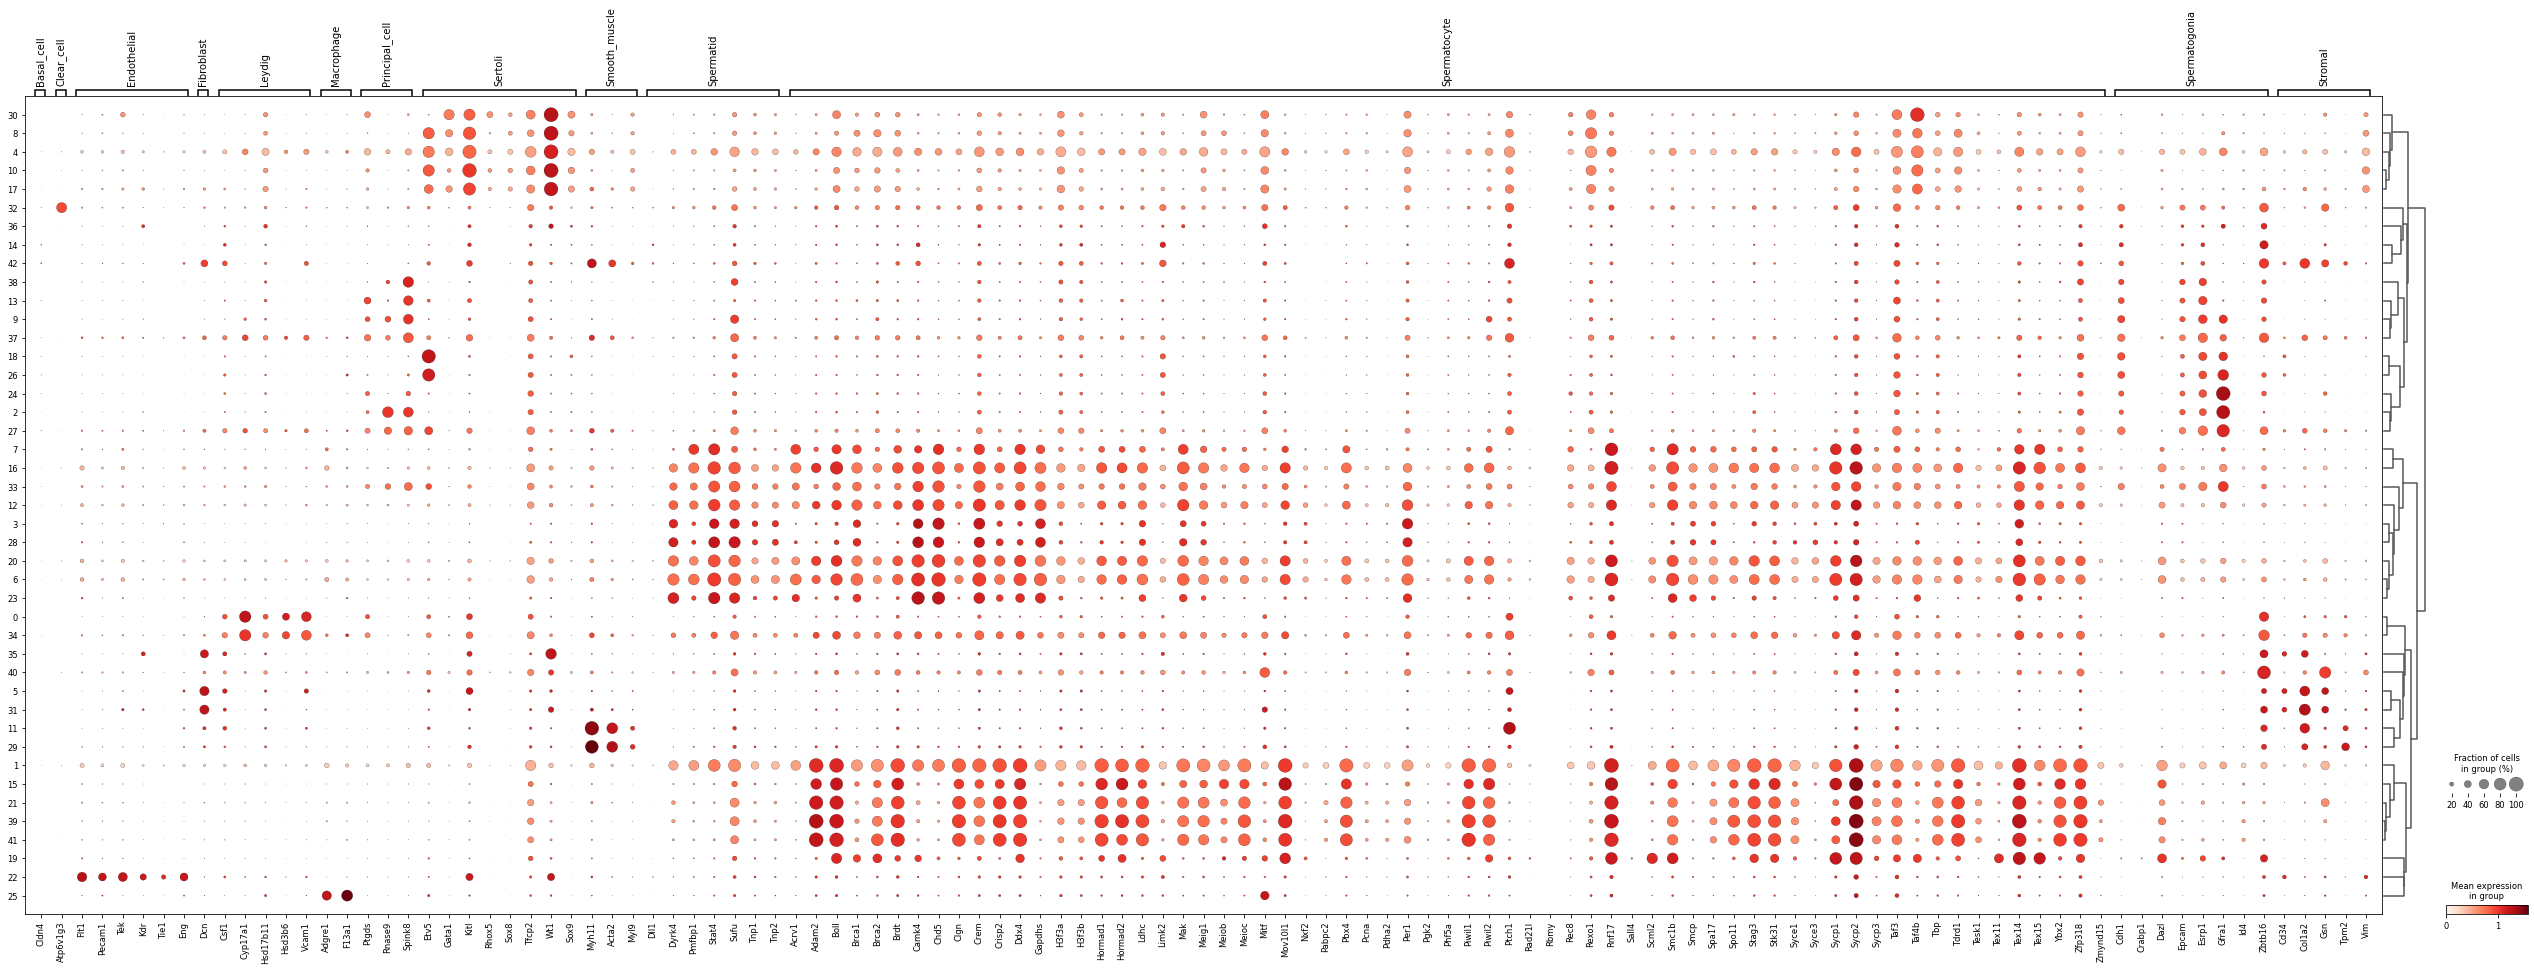

In [92]:
my_markers_df = pd.read_csv("IGVF_curated_markers.csv")
my_markers_df = my_markers_df[my_markers_df['Gene'].isin(adata.var_names)]
my_markers_df = my_markers_df[my_markers_df['Tissue'] == 'GonadsMale']

marker_genes_dict = my_markers_df.groupby('Subtype')['Gene'].agg(list).to_dict()


sc.pl.dotplot(adata, marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)
